In [1]:
import json
from itertools import product

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import numpy as np

%matplotlib inline

theses = '../data/theses_dump_21-03-2017.json'
collections = '../data/collections_dump_21-03-2017.json'

def jl_to_df(fname):
    with open(fname) as f:
        return pd.DataFrame([json.loads(line) for line in f])

In [2]:
collections = jl_to_df(collections)
theses = jl_to_df(theses)

# Create university MongoDB collection data

In [3]:
collections.head()

,_id,name
0,com_10024_1,Seinäjoen ammattikorkeakoulu
1,com_10024_4,Yrkeshögskolan Arcada
2,com_10024_5,Jyväskylän ammattikorkeakoulu
3,com_10024_6,Metropolia Ammattikorkeakoulu
4,com_10024_10,Lahden ammattikorkeakoulu


In [4]:
universities = collections[collections['_id'].apply(lambda x: 'com' in x)]

In [5]:
universities.to_json("collections_sample.json")

# Create degree MongoDB collection data

In [6]:
university_ids = theses['collections'].apply(lambda xs: [x for x in xs if 'com' in x])
degree_ids = theses['collections'].apply(lambda xs: [x for x in xs if 'col' in x])

print("Theses with not 1 university:")
print(university_ids[university_ids.apply(len) != 1])
print("Theses with not 1 degree:")
print(degree_ids[degree_ids.apply(len) != 1])

# We only take the first id we find for universities and degrees
theses['university_id'] = university_ids.apply(lambda xs: xs[0] if len(xs) > 0 else '')
theses['degree_id'] = degree_ids.apply(lambda xs: xs[0] if len(xs) > 0 else '')

Theses with not 1 university:
Series([], Name: collections, dtype: object)
Theses with not 1 degree:
1835                        [col_10024_269, col_10024_279]
3071      [col_10024_1556, col_10024_1556, col_10024_1556]
5190                      [col_10024_1907, col_10024_1929]
5518                      [col_10024_1663, col_10024_1663]
9319                      [col_10024_1906, col_10024_1909]
24894                       [col_10024_161, col_10024_161]
40208                     [col_10024_79818, col_10024_397]
101357                    [col_10024_2157, col_10024_2157]
103577                  [col_10024_77341, col_10024_77341]
103584                      [col_10024_135, col_10024_135]
113179                      [col_10024_125, col_10024_125]
Name: collections, dtype: object


## Get list of topics for each degree

In [7]:
degree_topics = pd.DataFrame(theses.groupby(["degree_id"])["topics"].sum(), columns=["topics"]).reset_index()

# Careful here, we suppose that the groupby order is consistent
degree_topics['count'] = theses.groupby(["degree_id"]).size().values

In [8]:
degree_topics.head()

,degree_id,topics,count
0,col_10024_100,"[development project, lääkehoito, medication s...",46
1,col_10024_100099,"[stärkelse, hydrolysis, tga, bioplastic, starc...",1
2,col_10024_100100,"[civilkrishantering, humanitarian crisis, egen...",4
3,col_10024_101,"[konepajat, työssäoppiminen, ammatillinen kehi...",222
4,col_10024_102,"[tietokoneen helppokäyttötoiminnot, ergonomia,...",35


## Get matrix representation of topics by degree

In [9]:
ml = MultiLabelBinarizer(sparse_output=True)
M = ml.fit_transform(degree_topics['topics'])

In [10]:
# Filter out topics by frequency
# 80% of topics only appear once
MIN_TOPIC_COUNT = 2
print(M.shape)
mask = np.array(M.sum(axis=0) > MIN_TOPIC_COUNT).flatten()
M = M[:, mask]
print(M.shape)

(999, 142546)
(999, 25490)


## Do TFIDF

Tfid was proven to be important, because without it most popular degrees (liiketalouden) will lie apart, and not within a cluesr

In [11]:
M = TfidfTransformer().fit_transform(M)

## Get x, y coordinates for each degree

TSNE results vary between runs, should write about how to detect a good result, and the conditions for convergence.

It is highly recommended to use another dimensionality reduction
method (e.g. PCA for dense data or TruncatedSVD for sparse data)
to reduce the number of dimensions to a reasonable amount (e.g. 50)
if the number of features is very high. This will suppress some
noise and speed up the computation of pairwise distances between
samples. For more tips see Laurens van der Maaten's FAQ [2].

Should consider whether removing degrees that have a less than certain number of thesis offers better performance for tsne.

In [12]:
pca = PCA(n_components=50)
pca.fit_transform(M.T.toarray())

array([[ -1.19719505e-02,  -1.16699315e-02,  -1.90218457e-03, ...,
          2.20971286e-04,   2.07228656e-03,   1.60804643e-03],
       [ -5.50550888e-03,   4.22933927e-02,   2.40071035e-02, ...,
          7.22710782e-03,  -3.77924207e-03,   9.17763955e-03],
       [ -1.15294485e-02,   1.69983737e-02,   9.73591183e-03, ...,
          6.68793197e-03,   9.26723125e-03,   9.71407085e-03],
       ..., 
       [ -1.64001596e-02,   4.99299372e-03,   2.27403455e-04, ...,
         -2.66288286e-03,  -1.80673834e-02,  -5.29847043e-03],
       [ -1.70376309e-02,  -1.64686418e-02,  -4.76687411e-03, ...,
         -2.44847855e-03,   7.28568465e-03,   3.98266426e-04],
       [ -9.67789454e-03,   3.19982871e-06,  -1.41276785e-02, ...,
          1.07883257e-03,   1.43147773e-03,  -6.73993033e-03]])

In [13]:
pca.components_.shape

(50, 999)

In [14]:
tsne = TSNE()
tsne.fit_transform(pca.components_.T)

array([[ -6.89708898,  -1.10884949],
       [ -7.00040315,   1.13247701],
       [-10.91275138,  -3.06716113],
       ..., 
       [-10.97184505,  -1.52739369],
       [-10.60587052,   6.70611461],
       [-15.82565826,   1.63543532]])

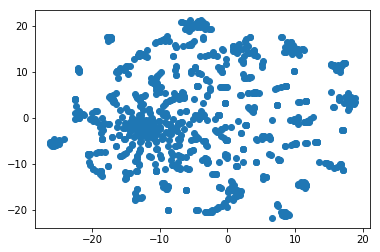

In [15]:
plt.scatter(tsne.embedding_[:, 0], tsne.embedding_[:, 1])

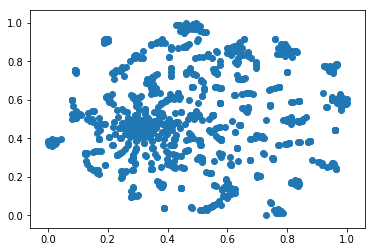

In [16]:
mms = MinMaxScaler()
embeddings = mms.fit_transform(tsne.embedding_)
plt.scatter(embeddings[:, 0], embeddings[:, 1])

In [17]:
embeddings.shape

(999, 2)

In [18]:
degree_topics.shape

(999, 3)

In [19]:
# Add x, y coordinates
degree_topics['x'] = embeddings[:, 0]
degree_topics['y'] = embeddings[:, 1]

# Add university_id, university_name, degree_name
# NOTE: degree_topics loses one row because inner join, instead of left join
collection_university_map = pd.DataFrame(theses.groupby(["degree_id", "university_id"]).groups.keys(), columns=["degree_id", "university_id"])
degree_topics = degree_topics.merge(collections.rename(columns={'_id': 'degree_id', 'name': 'degree_name'}))
degree_topics = degree_topics.merge(collection_university_map)
degree_topics = degree_topics.merge(collections.rename(columns={'_id': 'university_id', 'name': 'university_name'}))

In [21]:
degree_topics

,degree_id,topics,count,x,y,degree_name,university_id,university_name
0,col_10024_100,"[development project, lääkehoito, medication s...",46,0.428127,0.481493,Sosiaali- ja terveysalan kliininen asiantuntij...,com_10024_15,Turun ammattikorkeakoulu
1,col_10024_101,"[konepajat, työssäoppiminen, ammatillinen kehi...",222,0.091310,0.532954,Kone- ja tuotantotekniikka,com_10024_15,Turun ammattikorkeakoulu
2,col_10024_102,"[tietokoneen helppokäyttötoiminnot, ergonomia,...",35,0.579139,0.663996,Kuntoutus (ylempi AMK),com_10024_15,Turun ammattikorkeakoulu
3,col_10024_103,"[omakuvat, omaelämäkerrallisuus, elämäkerrat, ...",66,0.552830,0.520201,Kuvataide,com_10024_15,Turun ammattikorkeakoulu
4,col_10024_104,"[lääkeaineet, ich, lääkkeet, epäpuhtaudet, rek...",15,0.877151,0.385166,Laboratorioala,com_10024_15,Turun ammattikorkeakoulu
5,col_10024_105,"[tapaamisoikeus, oikeustradenomi, lapsen huolt...",841,0.005457,0.379497,Liiketalous,com_10024_15,Turun ammattikorkeakoulu
6,col_10024_105049,"[information magazine, future magazine, munici...",4,0.412762,0.865624,"Culture and Arts, Leadership and Service Desig...",com_10024_15,Turun ammattikorkeakoulu
7,col_10024_106,"[työilmapiiri, työviihtyvyys, työhyvinvointi, ...",97,0.664961,0.544489,Liiketoiminnan logistiikka,com_10024_15,Turun ammattikorkeakoulu
8,col_10024_107,"[puuteollisuus, muoviteollisuus, materiaalit, ...",110,0.846151,0.491139,Muotoilu,com_10024_15,Turun ammattikorkeakoulu
9,col_10024_108,"[kitara, musiikkipedagogiikka, pedagogiikka, m...",98,0.091823,0.750930,Musiikki,com_10024_15,Turun ammattikorkeakoulu


(830, 8)


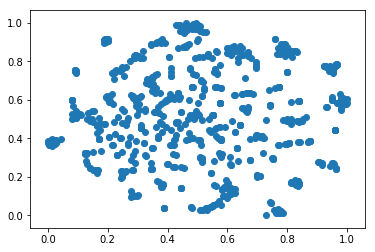

In [22]:
MIN_THESIS_COUNT = 10
most_popular = degree_topics[degree_topics['count'] > MIN_THESIS_COUNT]
print(most_popular.shape)
plt.scatter(most_popular['x'], most_popular['y'])

## Save degree data

In [23]:
degree_topics = degree_topics.rename(columns={'degree_id': '_id', 'degree_name': 'name'})
degree_topics['university'] = degree_topics.apply(lambda x: {'_id': x['university_id'], 'name': x['university_name']}, axis=1)
degree_topics[['_id', 'name', 'x', 'y', 'university']].to_json('../frontend/frontend/app/components/dashboard/degrees.json', orient='records')